---
---
# Solving TQD for a specific time of evolutiom $\tau$
---
---

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy.physics.quantum import TensorProduct as ts
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.matrices import msigma
from sympy.plotting import plot
from sympy import lambdify

import pickle
from qutip import *

---
## $\tau = 100$
---

### Functions

In [2]:
# -------------- f(t) = t/T ; g(t) = f(t) --------------------------------
def Hi_coef_lin(t,args):
    T = args['T']
    return (1 - t/T)
def Hm_coef_lin(t,args):
    T = args['T']
    return (1-t/T)*t/T
def Hf_coef_lin(t,args):
    T = args['T']
    return t/T

# ------ f(t)= (t/T)^(1/3) = s ; g(t) = t/T --------------------------------
def Hi_coef_cbrt(t,args):
    T = args['T']
    return (1 - np.cbrt(t/T))
def Hm_coef_cbrt(t,args):
    T = args['T']
    return (1-np.cbrt(t/T))*np.cbrt(t/T)
def Hf_coef_cbrt(t,args):
    T = args['T']
    return t/T

# ------ f(t) = sin(πt/2T) ; g(t) = sin(πt/2T) ------------------
def Hi_coef_sin(t,args):
    T = args['T']
    π = np.pi
    return (1 - np.sin(π*(t/T)/2))
def Hm_coef_sin(t,args):
    T = args['T']
    π = np.pi
    return (1 - np.sin(π*(t/T)/2))*np.sin(π*(t/T)/2)
def Hf_coef_sin(t,args):
    T = args['T']
    π = np.pi
    return np.sin(π*(t/T)/2)

---
### $H_{ad}$

In [3]:
qI, qx, qy, qz = qeye(2) ,sigmax(), sigmay(), sigmaz()

In [4]:
qHi = tensor(qx,qx,qI) + tensor(qy,qy,qI)
qHm = tensor(qI,qx,qx) + tensor(qI,qy,qy)
qHf = tensor(qz,qI,qz) + tensor(qI,qz,qz)

In [5]:
qHad_lin = [[qHi, Hi_coef_lin], [qHm, Hm_coef_lin], [qHf, Hf_coef_lin]]
qHad_cbrt = [[qHi, Hi_coef_cbrt], [qHm, Hm_coef_cbrt], [qHf, Hf_coef_cbrt]]
qHad_sin = [[qHi, Hi_coef_sin], [qHm, Hm_coef_sin], [qHf, Hf_coef_sin]]

---

In [6]:
tau_list = [10**(-3+8*i*.005) for i in list(np.arange(25,175))] #[0.01,...,9120] evolution time
TT = tau_list[100]
t_list = np.linspace(0,10*TT,100000)
w = t_list.shape[0]-1 # last t index in t_list

TT

100.0

---
### Initial Conditions

In [7]:
psi0 = tensor(bell_state('11'),ket('1'))
rho0 = ket2dm(psi0)

---
### Evolution

In [8]:
options = Options()
# options.nsteps = 100000
# options.atol = 1e-12
# options.rtol= 1e-12
print(options)


Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          4
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False



In [9]:
qH = [qHad_lin, qHad_cbrt, qHad_sin]
Erg_func = []
for H in qH:
    result = mesolve(H,rho0,t_list, args={'T': TT})
    rho_t = result.states
    erg_t = []
    for _t in range(len(t_list)):
    #----spectral decomposition of H0------------------------------------
        ϵ, ϵ_v = qz.eigenstates(sort='low')
    #----spectral decomposition of rho(t)----------------------------------
        rhored = rho_t[_t].ptrace(2)
        r, r_v = rhored.eigenstates(sort='high')
    #----calculating ergotropy-------------------------------------------
        vr_ve = np.array([[((r_v[0].dag()*ϵ_v[0]).norm())**2, ((r_v[1].dag()*ϵ_v[0]).norm())**2],
                            [((r_v[0].dag()*ϵ_v[1]).norm())**2, ((r_v[1].dag()*ϵ_v[1]).norm())**2]])
        erg_t.append(
            np.sum(np.outer(r,ϵ)*(vr_ve- np.identity(2))/2)
                    )
    Erg_func.append(erg_t)

---
### Saving Erg

In [232]:
with open(("data/Erg/TT" + str(TT)+'_len'+str(len(t_list))+'_'+str(t_list[-1])+'_Ergs_adb.data'), "wb") as fp:   #Pickling
    pickle.dump(Erg_func, fp)

---
### Loading Erg

In [10]:
# Erg_func = []
with open ("data/Erg/TT" + str(TT)+'_len'+str(len(t_list))+'_'+str(t_list[-1])+'_Ergs_adb.data', 'rb') as fp:
    Erg_func = pickle.load(fp)

---
### Plotting Erg

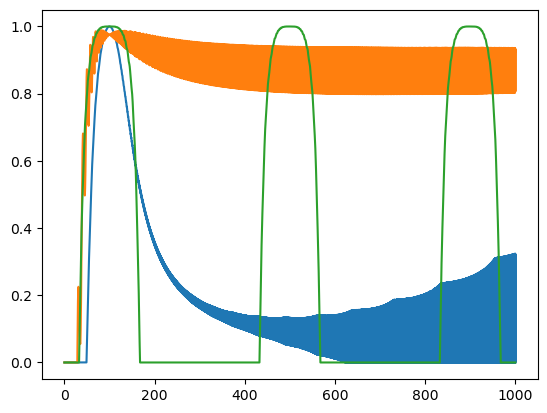

In [11]:
for _y in Erg_func:
    plt.plot(t_list,_y)
plt.show()

---
---
## TQD 
---
---

### Symbolic $H_{ad}$

In [13]:
sI,sx,sy,sz = sp.eye(2),msigma(1),msigma(2),msigma(3)
t = sp.symbols(r't', real=True, positive=True)
f = sp.Function('f')(t)
g = sp.Function('g')(t)

In [20]:
f, g = t/TT, t/TT
hbar, Omg = 1, 1

In [21]:
sHi = (ts(sx,sx,sI)+ts(sy,sy,sI))*hbar*Omg
sHm = (ts(sI,sx,sx)+ts(sI,sy,sy))*hbar*Omg
sHf = (ts(sz,sI,sz) + ts(sI,sz,sz))*hbar*Omg

sHad = (1-f)*sHi + f*(1-f)*sHm + g*sHf
sHad

Matrix([
[0.02*t,                   0,                   0,          0,          0,                   0,                   0,      0],
[     0,             -0.02*t, 0.02*t*(1 - 0.01*t),          0,          0,                   0,                   0,      0],
[     0, 0.02*t*(1 - 0.01*t),                   0,          0, 2 - 0.02*t,                   0,                   0,      0],
[     0,                   0,                   0,          0,          0,          2 - 0.02*t,                   0,      0],
[     0,                   0,          2 - 0.02*t,          0,          0,                   0,                   0,      0],
[     0,                   0,                   0, 2 - 0.02*t,          0,                   0, 0.02*t*(1 - 0.01*t),      0],
[     0,                   0,                   0,          0,          0, 0.02*t*(1 - 0.01*t),             -0.02*t,      0],
[     0,                   0,                   0,          0,          0,                   0,              

---
#### Eigenvectors of $H_{ad}$
---

In [22]:
m = sHad.eigenvects(chop=True)
# m = list(sHad.eigenvals())

In [23]:
e = [m[i//2][0] for i in range(len(m)*2)]
ev_ = [[tup[2][0], tup[2][1]] for tup in m]
ev = [val for sublist in ev_ for val in sublist]
evN = [vec/sp.sqrt((Dagger(vec)*vec)[0]) for vec in ev] 

---
### $H_{CD}$

In [24]:
Hcd = sum([sp.diff(vec,t)*Dagger(vec) for vec in evN],sp.zeros(8,8))

In [25]:
nonZero_index_Hcd = (np.transpose(np.nonzero(Hcd))).tolist()
for i in nonZero_index_Hcd:
    if i[0] == i[1]:
        nonZero_index_Hcd.remove(i)
print(nonZero_index_Hcd)

[[1, 2], [1, 4], [2, 1], [2, 4], [3, 5], [3, 6], [4, 1], [4, 2], [5, 3], [5, 6], [6, 3], [6, 5]]


In [28]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for i, j in zip(nonZero_index_Hcd, Hcd_dic):
    print(i[0],i[1],j)
    x = Hcd[int(i[0]),int(i[1])].evalf()
    
    lam_x = sp.lambdify(t, x, modules=['mpmath'])

    x_vals = np.linspace(0.01, 10*.99*TT, 100000, dtype=complex) #-------------(CAHNGE TOTAL TIME OF EVOLUTION!!!!)------------------

    y_vals = []
    for _x in x_vals:
        y_vals.append(complex(lam_x(_x)))
    
    
    Hcd_dic[j].append(np.round(y_vals, decimals=5))

1 2 H12
1 4 H14



KeyboardInterrupt



---
### Writting $H_{CD}$ components

In [ ]:
for H in Hcd_dic:
    with open('data/Hcd5TT/'+str(TT)+ H, 'wb') as fp:
        pickle.dump(Hcd_dic[H], fp) 

---
### Reading $H_{CD}$ components

In [26]:
Hcd_dic = { f"H{lst[0]}{lst[1]}": [] for lst in nonZero_index_Hcd}
for H in Hcd_dic:
    with open ('data/Hcd5TT/'+str(TT)+ H, 'rb') as fp:
        Hcd_dic[H] = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Hcd5TT/100.0H12'

---

In [17]:
Hcd_nonZeroPair = []
for i in Hcd_dic:
    for j in Hcd_dic:
        if i != j:
            # print((np.real(Hcd_dic[i][0]-Hcd_dic[j][0])==0))
            if len(np.unique(np.subtract(Hcd_dic[i][0],Hcd_dic[j][0])))<=2:
                if (i[1]<j[1]):                
                                     
                    x_vals = np.linspace(0.01, 5*.99*TT, 1000, dtype=complex)
                    y_vals_1 = Hcd_dic[i][0]
                    y_vals_2 = Hcd_dic[j][0]
                    if np.any(y_vals_1):

                        plt.plot(np.real(x_vals), np.real(y_vals_2))
                        print(i,j) 

                        Hcd_nonZeroPair.append([i,j])
                    # plt.plot(np.real(x_vals), np.real(y_vals_2))
plt.show()

NameError: name 'Hcd_dic' is not defined

---
### Interpolating

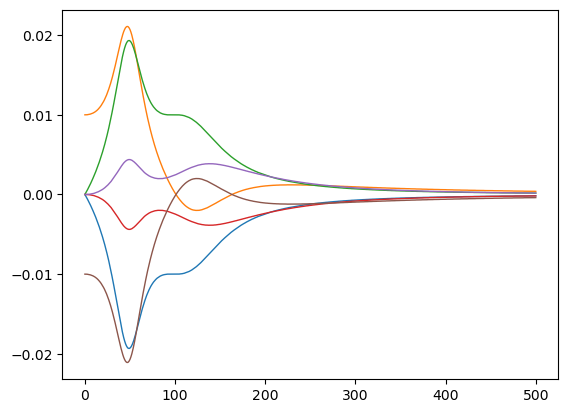

In [ ]:
S = []

for i in Hcd_nonZeroPair:
    S.append(
        Cubic_Spline(t_list[0], t_list[-1], np.real(Hcd_dic[i[1]][0]))
        )
for s in S:
    plt.plot(t_list, s(t_list), lw=1)
plt.show()

---

In [ ]:
HSD = [[qHi,Hi_coef_lin],[qHm,Hm_coef_lin],[qHf,Hf_coef_lin]]
# HSD = []
for i, s in zip(Hcd_nonZeroPair, S):
    H = np.zeros((8,8))
    H[int(i[0][1]),int(i[0][2])] +=1
    H[int(i[1][1]),int(i[1][2])] +=1
    HSD.append([1j*Qobj(H,dims = [[2, 2, 2], [2, 2, 2]]),s])

In [ ]:
result = mesolve(HSD,rho0,t_list, args={'T': TT})
rho_t = result.states
erg_t_HCD = []
for _t in range(len(t_list)):
#----spectral decomposition of H0------------------------------------
    ϵ, ϵ_v = qz.eigenstates(sort='low')
#----spectral decomposition of rho(t)----------------------------------
    rhored = rho_t[_t].ptrace(2)
    r, r_v = rhored.eigenstates(sort='high')
#----calculating ergotropy-------------------------------------------
    vr_ve = np.array([[((r_v[0].dag()*ϵ_v[0]).norm())**2, ((r_v[1].dag()*ϵ_v[0]).norm())**2],
                        [((r_v[0].dag()*ϵ_v[1]).norm())**2, ((r_v[1].dag()*ϵ_v[1]).norm())**2]])
    erg_t_HCD.append(
        np.sum(np.outer(r,ϵ)*(vr_ve- np.identity(2))/2)
                )


In [12]:
plt.plot(t_list,np.real(erg_t_HCD))
plt.plot(t_list,erg_t)

plt.show()

NameError: name 'erg_t_HCD' is not defined